# Imports 

In [8]:
from pathlib import Path

import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torchtext.data import Field
from torchtext.data import BucketIterator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import rna_ssp 
from rna_ssp import EncoderCNN

## Get data as torchtext dataset

In [2]:
curr_dir = Path('.')
data_dir = Path('./data')
sample_dot = 'bpRNA_CRW_9.dbn'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
src, trg = rna_ssp.get_data(data_dir)

In [5]:
src_train, src_val, trg_train, trg_val = train_test_split(src, trg, test_size = 0.2, random_state = 42, shuffle = True)
train_df = rna_ssp.get_df(src_train, trg_train)
val_df = rna_ssp.get_df(src_val , trg_val)

In [6]:
TEXT = Field(sequential = True, use_vocab = True, batch_first=True) 
TARGET = Field(sequential = True, use_vocab = False, batch_first=True, is_target = True, unk_token = 3, pad_token = 4)
train_ds = rna_ssp.DataFrameDataset(train_df, {'src': TEXT, 'trg': TARGET})
val_ds = rna_ssp.DataFrameDataset(val_df,  {'src': TEXT, 'trg': TARGET})
TEXT.build_vocab(train_ds)
trg_pad_idx = 4

In [7]:
train_iter, val_iter = BucketIterator.splits(
        (train_ds, val_ds),
        batch_sizes=(64, 64),
        sort=True,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False, 
)

## Train CNN model for predicting RNA secondary structure

In [9]:
model = EncoderCNN(emb_dim=100, vocab_size=len(TEXT.vocab), output_dim=3, dropout = 0.2)
model.to(device)

EncoderCNN(
  (emb): Embedding(35, 100)
  (conv1): Conv1d(100, 3, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(200, 100, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv3): Conv1d(100, 200, kernel_size=(11,), stride=(1,), padding=(5,))
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [10]:
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss(ignore_index = trg_pad_idx)
scheduler = StepLR(opt, step_size=1, gamma=0.94)
epochs = 10

In [ ]:
%%time
_, val_mean_losses = rna_ssp.train(model, opt, loss_func, train_iter, val_iter, epochs, scheduler, print_every = 2)

Epoch: 103, Training Loss: 0.476, Validation Loss: 0.441


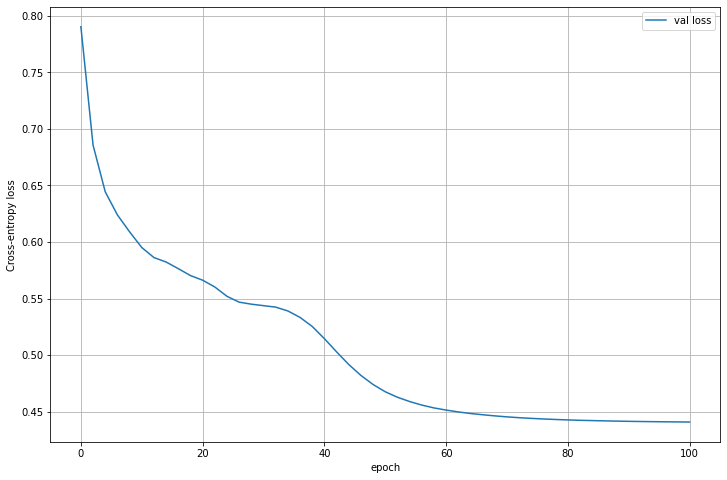

In [41]:
plt.figure(figsize = (12, 8))
print(f'Epoch: {epoch}, Training Loss: {epoch_loss:.3f}, Validation Loss: {val_loss:.3f}')
plt.plot(np.arange(0, len(val_mean_losses)), val_mean_losses, label = 'val loss')
plt.xticks(np.arange(0, int(len(val_mean_losses)), 10), np.arange(0, len(val_mean_losses)*2, 20))
plt.legend(loc = 'best')
plt.grid(True)
plt.ylabel('Cross-entropy loss')
plt.xlabel('epoch')
plt.show()

## save model

In [ ]:
torch.save(model, 'rna_model_nw_inv3_1.pth')

# Predictions and visualization 

## get predictions from pre-trained model

In [ ]:
model_trained = torch.load('rna_model_nw_inv3.pth', map_location=device)

In [14]:
result_df = rna_ssp.get_predictions(val_iter, model_trained)
result_df = rna_ssp.ind2seq(result_df)

## Visualize results

In [15]:
N = 3700
pred_string = result_df['sec_pred_db'][N]
true_string = result_df['sec_true_db'][N]

prim_str = result_df['primary'][N]
prim_str = [TEXT.vocab.itos[ind] for ind in prim_str]
prim_str = ''.join(prim_str)


pred: ((((((...((((.......))))((((((.......))))))...(((((.......)))))))))))).
true: (((((((..((((.......))))((((((.......))))))...(((((.......)))))))))))).
corr: ((((((...((((.......))))((((((.......))))))...(((((.......)))))))))))..


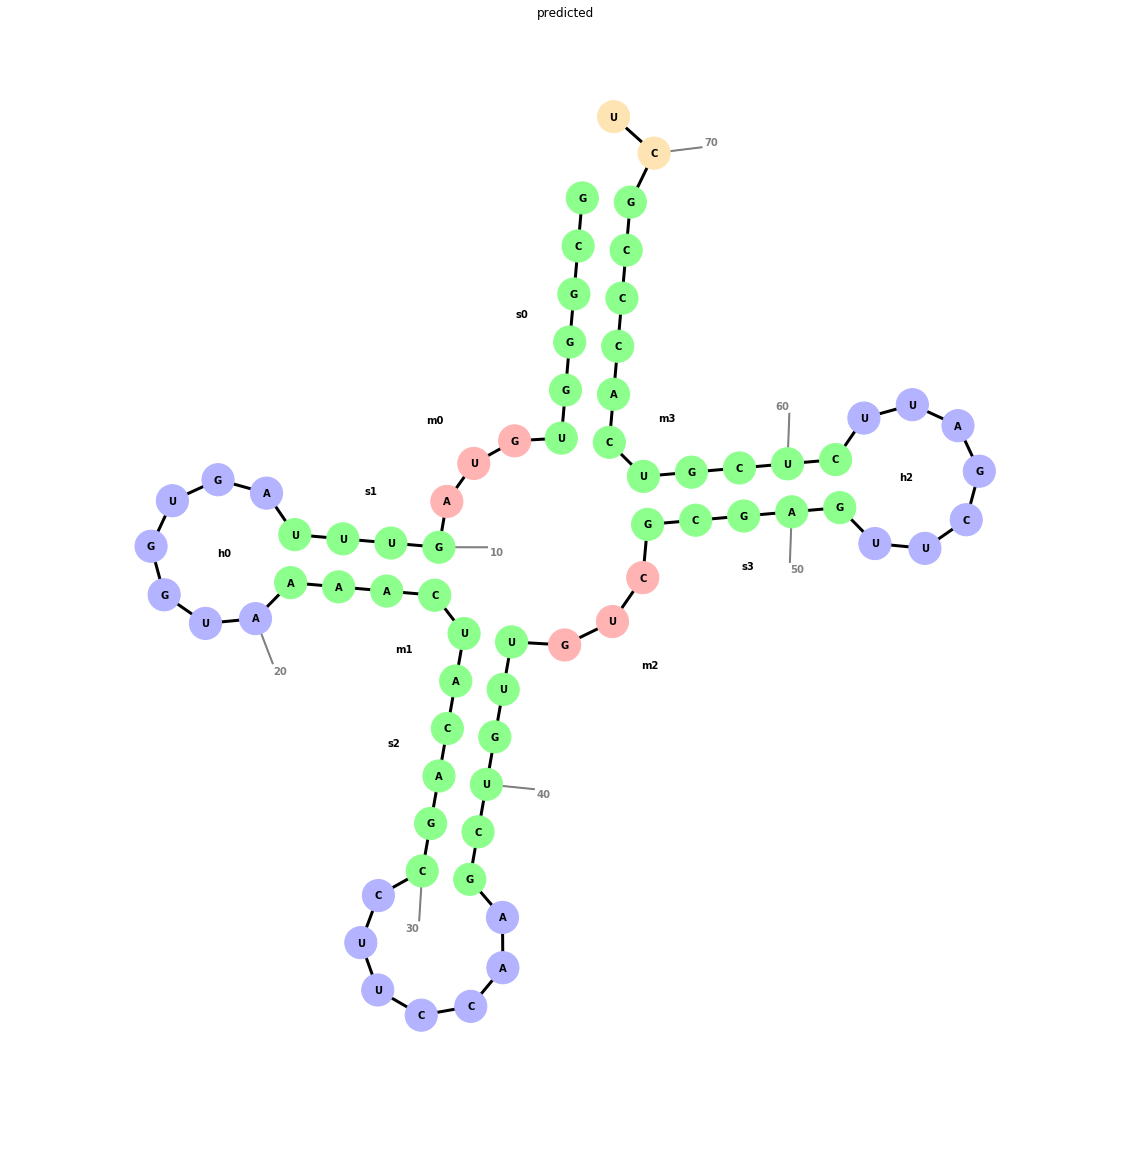

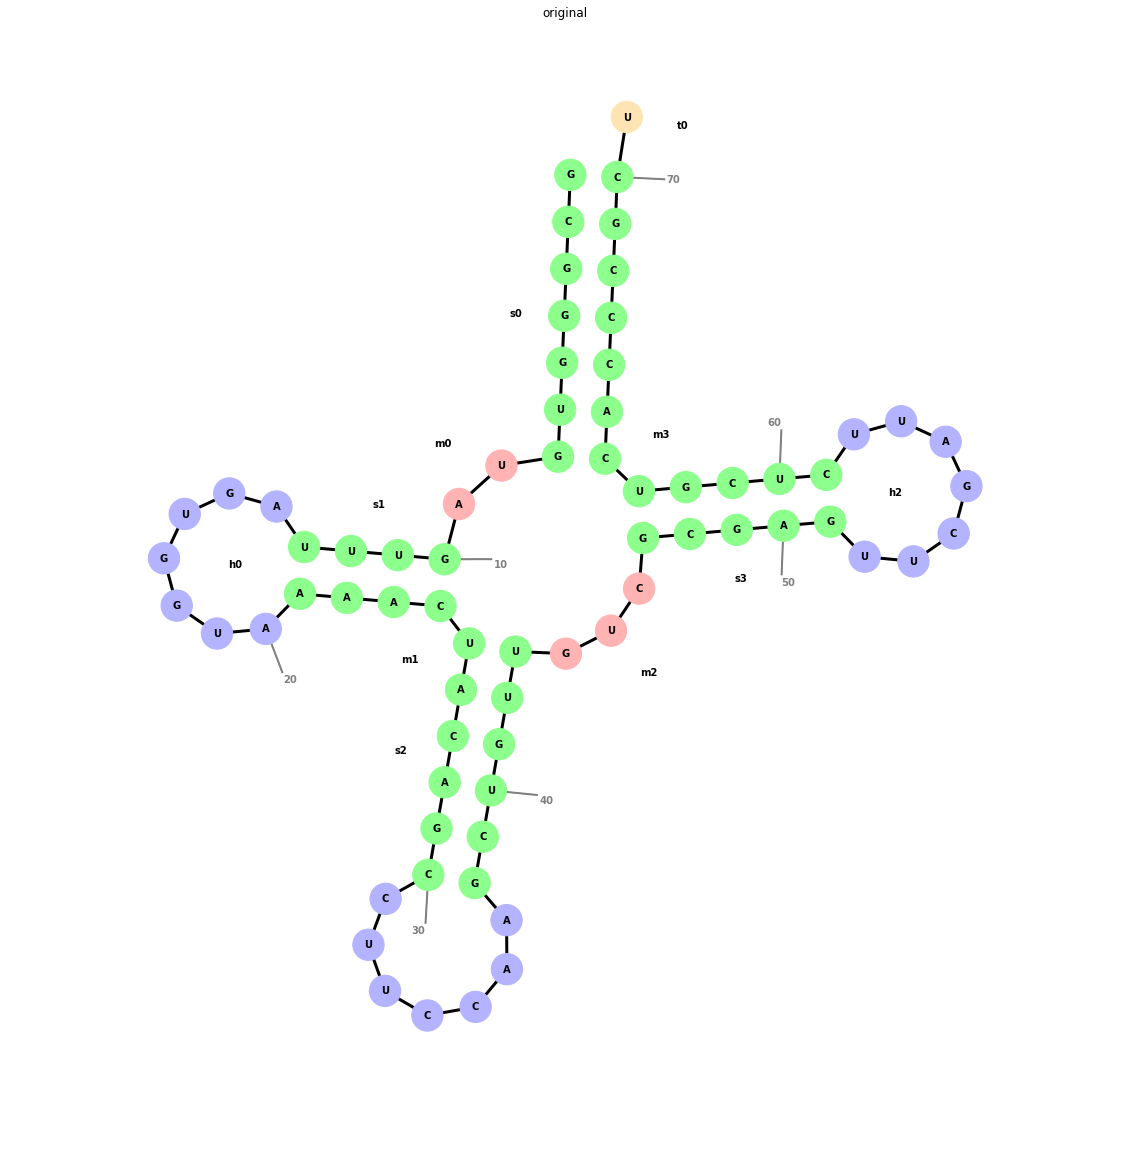

In [16]:
rna_ssp.visualize(prim_str,pred_string, true_string)